In [92]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import copy
import tqdm
import random

import matplotlib.pyplot as plt

from optimizers import SignSGD, GNSGD
from get_data import get_imbalanced_data
from ml_collections import ConfigDict

from algorithms import GD_array, SIGN_array, Adam_array, RMS_array, Newton_array

%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [195]:
num_epochs = 700 # number of training epochs


#init = "zero" # how to initialize the model
init = "zero"
seed = 100


#c = 100
#n=2*c
#d = 300
#group_size = 2
#group_array = [0] + [1]*c

alpha = 0.7


group_array = []
group_size = 5



c = 2 ** group_size - 1

for i in range(group_size):
    group_array += [i]* (2**i)

d = (group_size + 1) * 2**group_size

n = group_size * 2**group_size


config = ConfigDict({"num_epochs": num_epochs,
                      "init": init, 
                      "seed": seed,
                      "group_size": group_size,
                      "group_array": group_array,
                      "c": c,
                      "n": n,
                      "d": d,
                      "alpha": alpha})

In [104]:
total_loss_array = {"GD": None, "SignGD": None, "Newton": None, "Adam": None, "RMS": None}
group_loss_array = {"GD": None, "SignGD": None, "Newton": None, "Adam": None, "RMS": None}
prob_array = {"GD": None, "SignGD": None, "Newton": None, "Adam": None, "RMS": None}
total_acc_array = {"GD": None, "SignGD": None, "Newton": None, "Adam": None, "RMS": None}



In [196]:
total_loss_array["GD"], group_loss_array["GD"], total_acc_array["GD"], prob_array["GD"] = \
    GD_array(config, lr = 5.0, momentum=0.0)
 

100%|██████████| 700/700 [00:01<00:00, 456.15it/s]


In [197]:
total_loss_array["SignGD"], group_loss_array["SignGD"], total_acc_array["SignGD"], prob_array["SignGD"] = \
    SIGN_array(config, lr = 0.05, momentum=0.0)

100%|██████████| 700/700 [00:01<00:00, 524.28it/s]


In [21]:
total_loss_array["Adam"], group_loss_array["Adam"], total_acc_array["Adam"], prob_array["Adam"] = \
    Adam_array(config, lr = 0.1)

100%|██████████| 500/500 [00:06<00:00, 77.20it/s]


In [22]:
total_loss_array["RMS"], group_loss_array["RMS"], total_acc_array["RMS"], prob_array["RMS"] = \
    RMS_array(config, lr = 0.01)

100%|██████████| 500/500 [00:06<00:00, 75.88it/s]


In [46]:
config.num_epochs = 10
total_loss_array["Newton"], group_loss_array["Newton"], total_acc_array["Newton"], prob_array["Newton"] = \
    Newton_array(config, lr = 1.0, damp=0.001)

100%|██████████| 10/10 [00:01<00:00,  8.59it/s]


In [32]:
for i in range(90):
    total_acc_array["Newton"] += [total_acc_array["Newton"][-1]]

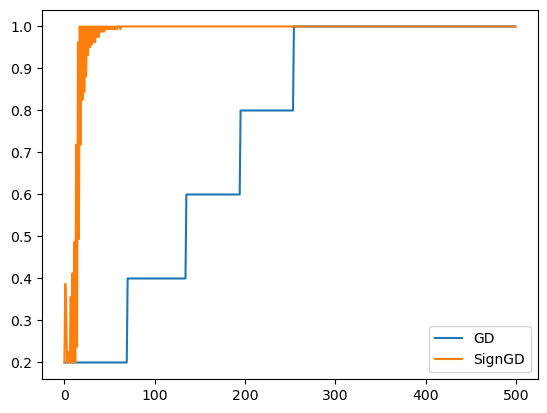

In [149]:
epoch_show = 500

x = [i for i in range(num_epochs)]

plt.plot(x[:epoch_show], total_acc_array["GD"][:epoch_show], label = "GD")
plt.plot(x[:epoch_show], total_acc_array["SignGD"][:epoch_show], label = "SignGD")
#plt.plot(x[:epoch_show], total_acc_array["Adam"][:epoch_show], label = "Adam")
#plt.plot(x[:epoch_show], total_acc_array["RMS"][:epoch_show], label = "RMS")
#plt.plot(x[:epoch_show], total_acc_array["Newton"][:epoch_show], label = "Newton")

plt.legend()
plt.show()

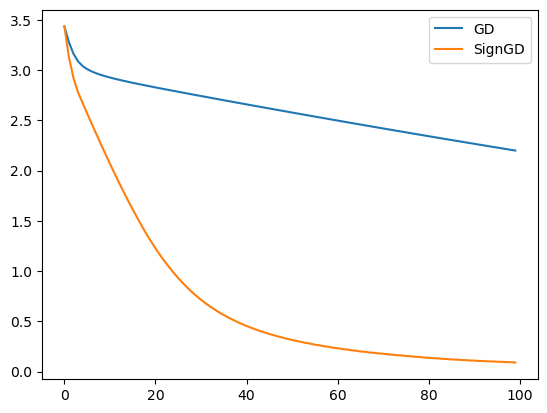

In [150]:
epoch_show = 100

x = [i for i in range(num_epochs)]

plt.plot(x[:epoch_show], total_loss_array["GD"][:epoch_show], label = "GD")
plt.plot(x[:epoch_show], total_loss_array["SignGD"][:epoch_show], label = "SignGD")
#plt.plot(x[:epoch_show], total_loss_array["Adam"][:epoch_show], label = "Adam")
#plt.plot(x[:epoch_show], total_loss_array["RMS"][:epoch_show], label = "RMS")
#plt.plot(x[:epoch_show], total_loss_array["Newton"][:epoch_show], label = "Newton")

plt.legend()
plt.show()

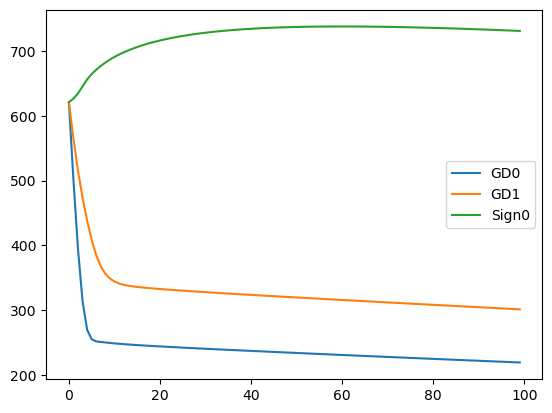

In [125]:
epoch_show = 100

x = [i for i in range(num_epochs)]

plt.plot(x[:epoch_show], group_loss_array["GD"][0][:epoch_show], label = "GD0")
plt.plot(x[:epoch_show], group_loss_array["GD"][1][:epoch_show], label = "GD1")
plt.plot(x[:epoch_show], group_loss_array["GD"][group_size-1][:epoch_show], label = "GDlast")

plt.legend()
plt.show()


In [213]:
num_epochs = 4000

# Note that alpha = 0.0

alpha = [0.1, 0.3, 0.5, 0.7, 0.9]

total_loss_array["GD"], group_loss_array["GD"], prob_array["GD"], norm_array["GD"] = GD_array(alpha, num_epochs)
total_loss_array["SignGD"], group_loss_array["SignGD"], prob_array["SignGD"], norm_array["SignGD"] = SignGD_array(alpha, num_epochs)
#total_loss_array["Adam"], group_loss_array["Adam"], prob_array["Adam"], norm_array["Adam"] = Adam_array(alpha, num_epochs)
total_loss_array["GNSGD"], group_loss_array["GNSGD"], prob_array["GNSGD"], norm_array["GNSGD"] = GNGD_array(alpha, num_epochs)

100%|██████████| 4000/4000 [00:02<00:00, 1671.29it/s]


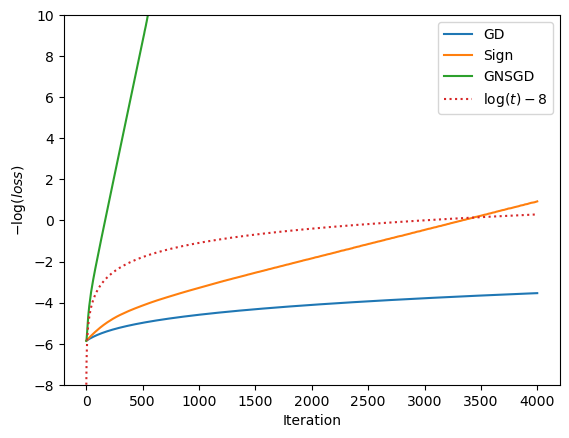

In [214]:
x = [i for i in range(num_epochs)]

val_1 = [-math.log(total_loss_array["GD"][i]) for i in range(num_epochs)]
val_2 = [-math.log(total_loss_array["SignGD"][i]+1e-6) for i in range(num_epochs)]
#val_3 = [-math.log(total_loss_array["Adam"][i]+1e-6) for i in range(num_epochs)]
val_4 = [-math.log(total_loss_array["GNSGD"][i]+1e-6) for i in range(num_epochs)]

plt.plot(x,val_1, label="GD")
plt.plot(x,val_2, label="Sign")
#plt.plot(x,val_3, label="Adam")
plt.plot(x,val_4, label="GNSGD")
plt.plot(x, [-8+ math.log(i+1) for i in x], linestyle= ':', label = r"$\log(t)-8$")
plt.legend()
plt.ylim((-8,10))
plt.xlabel("Iteration")
plt.ylabel(r"$-\log(loss)$")
plt.show()


In [121]:
X,y = get_imbalanced_data(config)


In [123]:
criterion = nn.CrossEntropyLoss()

def loss(W, X, y):

    W_transformed = W.view(config.c, config.d).t()
    output = torch.matmul(X, W_transformed)
    return criterion(output, y).mean()

In [198]:
from functorch import jacfwd
from functorch import hessian

param = torch.zeros(config.d * config.c)
#param = torch.randn(config.d * config.c)


H = hessian(loss, argnums=0)(param, X, y).clone()
grad = jacfwd(loss, argnums=0)(param, X, y).clone()


print(grad.shape)
print(H.shape)


/Users/gagikmagakyan/opt/anaconda3/lib/python3.8/site-packages/torch/_functorch/deprecated.py:92: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.hessian is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.hessian instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('hessian')
/Users/gagikmagakyan/opt/anaconda3/lib/python3.8/site-packages/torch/_functorch/deprecated.py:88: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacfwd is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacfwd instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecat

torch.Size([5952])
torch.Size([5952, 5952])


In [199]:
for i in range(config.c):
    for j in range(config.c):
        if i!=j:
            H[i*config.d: (i+1)*config.d, j*config.d: (j+1)*config.d] = \
                torch.zeros(config.d, config.d)

In [214]:
import tqdm

method = "GD"

if method == "SignGD":
    lr = 0.05

if method == "GD":
    lr = 5.0

def acc_calc(W, X, y):

    W_transformed = W.view(config.c, config.d).t()
    output = torch.matmul(X, W_transformed)
    pred = output.argmax(dim=1, keepdim=True).view(-1)
    return (pred == y).float().mean()



loss_values = []
loss_values_different = []
acc_values = []
param = torch.zeros(config.d * config.c)
param_0 = torch.zeros(config.d * config.c)

for i in tqdm.tqdm(range(config.num_epochs)):

    loss_values_different += [loss(param, X, y).item()]
    loss_values += [loss(param_0, X, y).item() + 1/2 * torch.matmul(param, torch.matmul(H, param)).item() +  torch.matmul(grad, param).item()]
    acc_values += [acc_calc(param, X, y).item()]

    if method == "SignGD":
        param = param - lr * torch.sign((torch.matmul(H, param) + grad))
    
    if method == "GD":
        param = param - lr * (torch.matmul(H, param) + grad)

  0%|          | 0/700 [00:00<?, ?it/s]/Users/gagikmagakyan/opt/anaconda3/lib/python3.8/site-packages/torch/_functorch/deprecated.py:88: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacfwd is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacfwd instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('jacfwd')
100%|██████████| 700/700 [04:09<00:00,  2.81it/s]


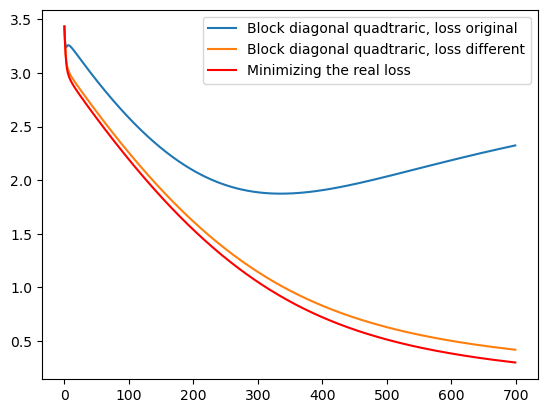

In [215]:
x = [i for i in range(config.num_epochs)]
plt.plot(x,loss_values, label = "Block diagonal quadtraric, loss original")
plt.plot(x,loss_values_different, label = "Block diagonal quadtraric, loss different")
plt.plot(x, total_loss_array[method][:config.num_epochs], label = "Minimizing the real loss", color = "red")

plt.legend()
plt.show()

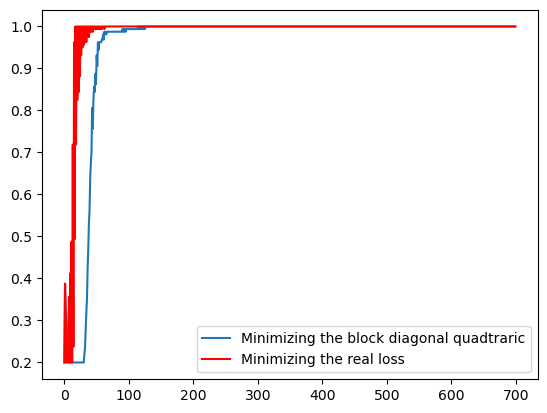

In [205]:
x = [i for i in range(config.num_epochs)]
plt.plot(x,acc_values, label = "Minimizing the block diagonal quadtraric")
plt.plot(x, total_acc_array[method][:config.num_epochs], label = "Minimizing the real loss", color="red")

plt.legend()
plt.show()

In [14]:
H = H.numpy()
L, V = np.linalg.eig(H)
evals = [L[i].real for i in range(len(L))]
evals.sort()
print(evals)

cut_evals = []

for i in range(len(evals)):
    if evals[i] > 0.0001:
        cut_evals.append(evals[i])

[-2.7537647e-10, -2.6244973e-10, -2.3709415e-10, -2.262761e-10, -2.1387825e-10, -1.87612e-10, -1.87612e-10, -1.8753574e-10, -1.7575545e-10, -1.6235915e-10, -1.6235915e-10, -1.5630143e-10, -1.5630143e-10, -1.5470776e-10, -1.5470776e-10, -1.2935572e-10, -1.2935572e-10, -1.2833022e-10, -1.1270551e-10, -1.1270551e-10, -1.1039435e-10, -1.1039435e-10, -1.04234635e-10, -1.04234635e-10, -1.04234635e-10, -1.04234635e-10, -1.04234635e-10, -1.04234635e-10, -1.04234635e-10, -1.04234635e-10, -1.04234635e-10, -1.04234635e-10, -1.04234635e-10, -9.3317895e-11, -9.3317895e-11, -8.1391116e-11, -8.1391116e-11, -7.018571e-11, -7.018571e-11, -6.577987e-11, -6.577987e-11, -6.577987e-11, -6.577987e-11, -6.577987e-11, -6.577987e-11, -6.577987e-11, -6.577987e-11, -6.577987e-11, -6.577987e-11, -6.577987e-11, -6.577987e-11, -6.577987e-11, -6.577987e-11, -6.577987e-11, -6.577987e-11, -6.577987e-11, -6.577987e-11, -6.577987e-11, -6.577987e-11, -6.577987e-11, -6.577987e-11, -6.342689e-11, -6.342689e-11, -6.060178e-

(array([882.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  14.]),
 array([0.00101042, 0.00121042, 0.00141042, 0.00161042, 0.00181042,
        0.00201042, 0.00221042, 0.00241042, 0.00261042, 0.00281042,
        0.00301042]),
 <BarContainer object of 10 artists>)

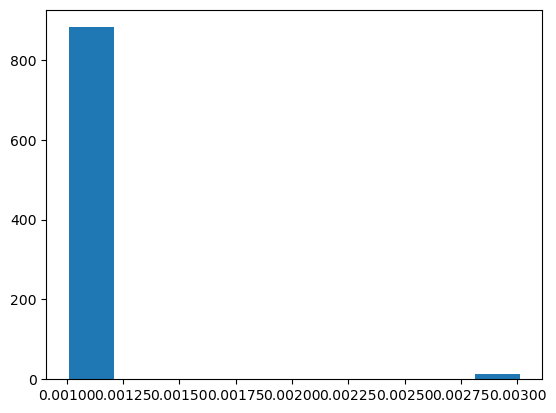

In [15]:
x = [i for i in range(len(cut_evals))]
plt.hist(cut_evals, bins=10)